<a href="https://colab.research.google.com/github/hungrycarpet/Quakedet/blob/main/earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from urllib import request
import numpy as np
import pandas as pd
import sklearn as sk
import os
import json
import csv
from sklearn.base import BaseEstimator,TransformerMixin
import sklearn
import xgboost
import tensorflow
from tensorflow import keras

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
columns=['mag', 'place', 'time', 'updated', 'tz', 'url', 'detail', 'felt', 'cdi',
       'mmi', 'alert', 'status', 'tsunami', 'sig', 'net', 'code', 'ids',
       'sources', 'types', 'nst', 'dmin', 'rms', 'gap', 'magType', 'type',
       'title', 'longitude', 'latitude', 'radius']



In [ ]:
def get_the_data(path='/content/usgs_data_big_file2 (1).csv'):
  l=[]
  with open(path,encoding='CP949') as fileob:
      fileob.readline()
      for line in fileob:
          l.append(dict(list(zip(columns,line.split(',')))))
  return pd.DataFrame(l,columns=columns)


In [75]:
data_frame=pd.read_csv('/content/all_month.csv',encoding='utf-8',na_values='None')

In [56]:
data_frame.shape

(10722, 22)

In [8]:
data_frame.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-03-22T19:13:40.610Z,19.223333,-155.390671,29.59,2.10,md,34.0,166.0,NaN,0.12,hv,hv72395852,2021-03-22T19:16:42.630Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.63,0.89,0.110,9.0,automatic,hv,hv
1,2021-03-22T19:10:16.504Z,61.797800,-151.618000,90.10,1.60,ml,NaN,NaN,NaN,0.41,ak,ak0213q9wixb,2021-03-22T19:14:44.891Z,"24 km SSW of Skwentna, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
2,2021-03-22T19:03:12.880Z,33.655667,-116.696167,11.26,0.94,ml,28.0,86.0,0.05735,0.34,ci,ci39587543,2021-03-22T19:06:55.230Z,"10km SSE of Idyllwild, CA",earthquake,0.53,0.97,0.108,26.0,automatic,ci,ci
3,2021-03-22T19:01:42.630Z,36.553833,-89.649498,9.28,2.35,md,11.0,77.0,0.10510,0.12,nm,nm60328502,2021-03-22T19:05:58.230Z,"4 km WSW of Howardville, Missouri",earthquake,0.71,1.13,0.190,9.0,reviewed,nm,nm
4,2021-03-22T18:45:29.770Z,38.835667,-122.810997,1.86,0.85,md,14.0,52.0,0.01228,0.02,nc,nc73540705,2021-03-22T18:54:06.939Z,"8km W of Cobb, CA",earthquake,0.26,0.70,NaN,1.0,automatic,nc,nc


In [ ]:
def value_counts(frame):
  for column in frame.columns:
    print(frame[column].value_counts())
    print('\n------------------------------------\n')



In [9]:
data_frame.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   2
magType               2
nst                3408
gap                1860
dmin               3146
rms                   0
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    3153
depthError            0
magError           2388
magNst             1930
status                0
locationSource        0
magSource             0
dtype: int64

In [10]:
data_frame.shape

(10722, 22)

In [ ]:
value_counts(data_frame)

In [11]:
def get_dtypes(frame):
  for column in frame.columns:
    print('{:10s}->'.format(column),frame[column].dtype)
get_dtypes(data_frame)

time      -> object
latitude  -> float64
longitude -> float64
depth     -> float64
mag       -> float64
magType   -> object
nst       -> float64
gap       -> float64
dmin      -> float64
rms       -> float64
net       -> object
id        -> object
updated   -> object
place     -> object
type      -> object
horizontalError-> float64
depthError-> float64
magError  -> float64
magNst    -> float64
status    -> object
locationSource-> object
magSource -> object


In [76]:
data1=data_frame.drop(columns=['updated','id','place','time'])

In [63]:
data1.isnull().sum()

latitude              0
longitude             0
depth                 0
mag                   2
magType               2
nst                3408
gap                1860
dmin               3146
rms                   0
net                   0
type                  0
horizontalError    3153
depthError            0
magError           2388
magNst             1930
status                0
locationSource        0
magSource             0
dtype: int64

In [65]:
data1.loc[data1.loc[:,'mag'].isnull(),:]

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
7029,38.762167,-122.729167,0.76,NaN,NaN,10.0,77.0,0.003415,0.04,nc,earthquake,0.32,0.48,NaN,NaN,reviewed,nc,nc
8207,36.421667,-98.807000,8.54,NaN,NaN,14.0,210.0,0.028794,0.07,ok,earthquake,NaN,0.30,NaN,NaN,reviewed,ok,ok


In [13]:
get_dtypes(data1)

latitude  -> float64
longitude -> float64
depth     -> float64
mag       -> float64
magType   -> object
nst       -> float64
gap       -> float64
dmin      -> float64
rms       -> float64
net       -> object
type      -> object
horizontalError-> float64
depthError-> float64
magError  -> float64
magNst    -> float64
status    -> object
locationSource-> object
magSource -> object


In [14]:
data1.head(5)

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,19.223333,-155.390671,29.59,2.10,md,34.0,166.0,NaN,0.12,hv,earthquake,0.63,0.89,0.110,9.0,automatic,hv,hv
1,61.797800,-151.618000,90.10,1.60,ml,NaN,NaN,NaN,0.41,ak,earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
2,33.655667,-116.696167,11.26,0.94,ml,28.0,86.0,0.05735,0.34,ci,earthquake,0.53,0.97,0.108,26.0,automatic,ci,ci
3,36.553833,-89.649498,9.28,2.35,md,11.0,77.0,0.10510,0.12,nm,earthquake,0.71,1.13,0.190,9.0,reviewed,nm,nm
4,38.835667,-122.810997,1.86,0.85,md,14.0,52.0,0.01228,0.02,nc,earthquake,0.26,0.70,NaN,1.0,automatic,nc,nc


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc215762b90>,
      dtype=object)

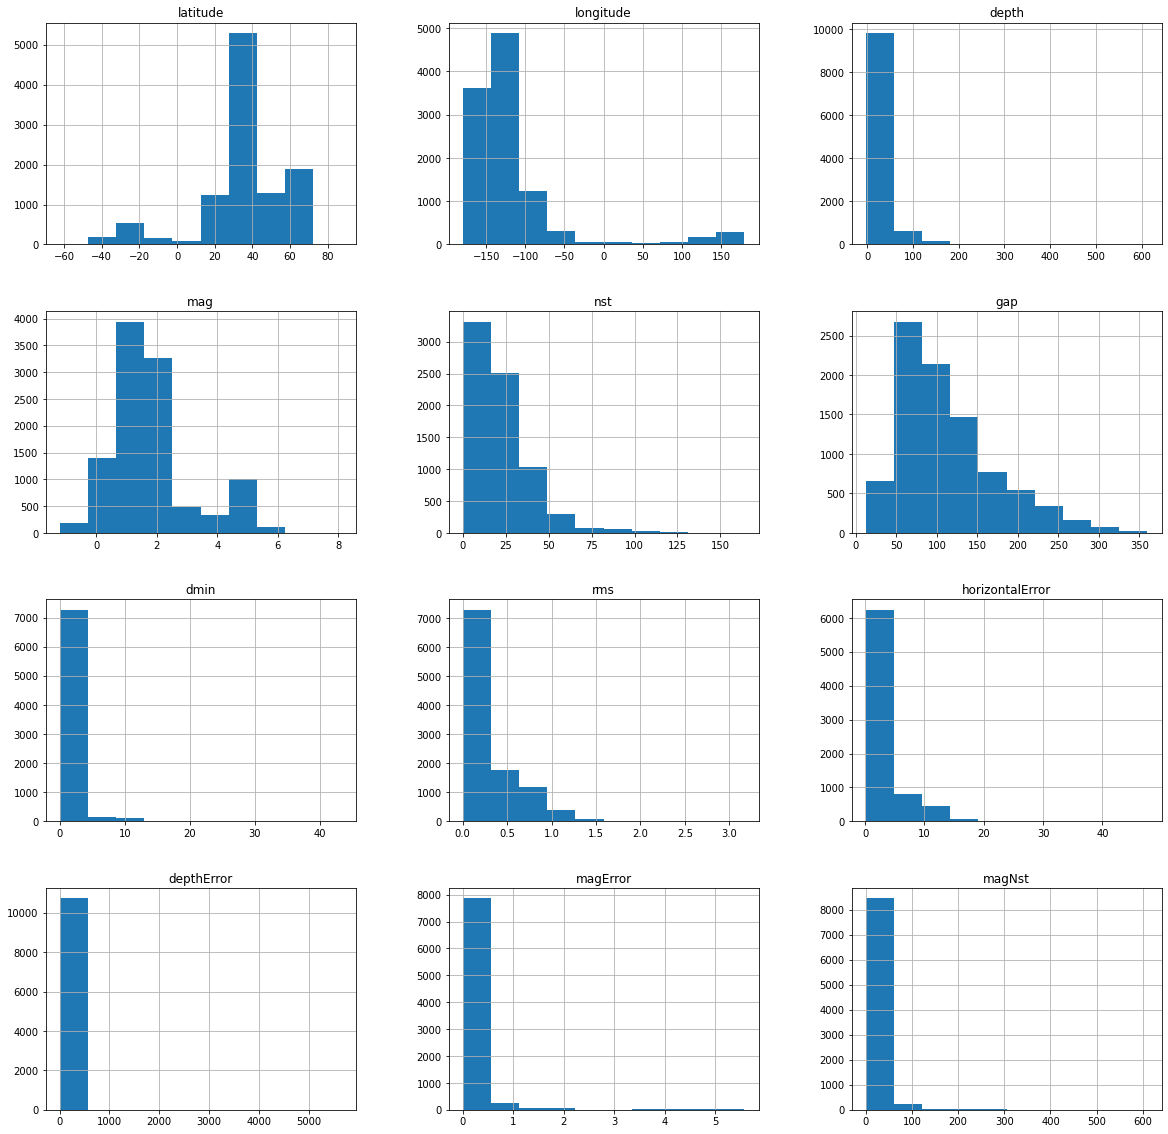

In [ ]:
data1.hist(figsize=(20,20))


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


In [16]:
from pandas import plotting 

In [17]:
from sklearn.model_selection import train_test_split

In [77]:
remove_nan_columns=['magType','net','type','status','locationSource','magSource','mag','latitude','longitude']
p=data1['magType'].notnull()
for column in remove_nan_columns[1:]:
  p=p&data1[column].notnull()
data2=data1.loc[p,:].copy()

In [68]:
data2.isnull().sum()

latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                3408
gap                1860
dmin               3146
rms                   0
net                   0
type                  0
horizontalError    3152
depthError            0
magError           2386
magNst             1928
status                0
locationSource        0
magSource             0
dtype: int64

In [78]:
data2.shape

(10720, 18)

In [79]:
np.random.seed(44)
shuffle1=data2.iloc[np.random.permutation(data2.shape[0]),:]

In [154]:
shuffle1.head()

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
5133,38.822833,-122.787333,1.59,0.19,md,10.0,75.0,0.010880,0.03,nc,earthquake,0.39,0.98,NaN,1.0,reviewed,nc,nc
8817,59.730500,-152.696800,88.90,1.50,ml,NaN,NaN,NaN,0.21,ak,earthquake,NaN,0.30,NaN,NaN,reviewed,ak,ak
6949,36.087333,-117.933000,5.06,1.09,ml,23.0,58.0,0.029220,0.15,ci,earthquake,0.21,0.52,0.203,13.0,reviewed,ci,ci
4745,38.824665,-122.846664,1.78,0.65,md,11.0,85.0,0.008477,0.03,nc,earthquake,0.30,0.75,NaN,1.0,automatic,nc,nc
4556,34.464333,-117.957167,8.53,1.16,ml,22.0,39.0,0.015420,0.09,ci,earthquake,0.18,0.29,0.165,17.0,reviewed,ci,ci


In [81]:
shuffle1.isnull().sum()

latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                3408
gap                1860
dmin               3146
rms                   0
net                   0
type                  0
horizontalError    3152
depthError            0
magError           2386
magNst             1928
status                0
locationSource        0
magSource             0
dtype: int64

In [82]:
train_data,test_data=train_test_split(shuffle1,test_size=0.12,random_state=43)
train_data,val_data=train_test_split(train_data,test_size=0.12,random_state=43)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9cf481ad0>,
      dtype=object)

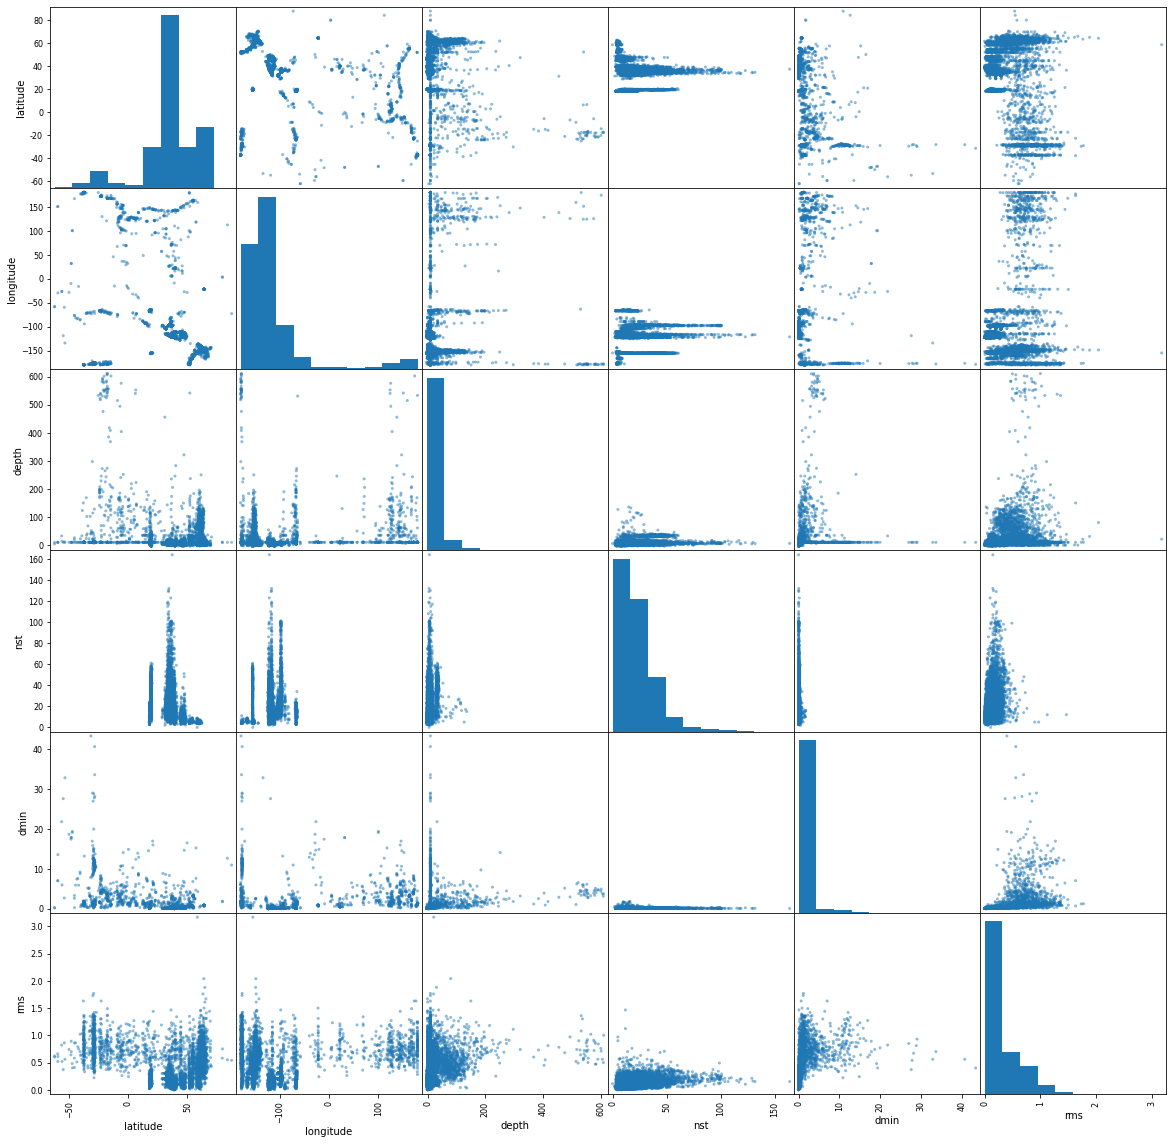

In [83]:
plotting.scatter_matrix(train_data[['latitude','longitude','depth','nst','dmin','rms']],
                        figsize=(20,20))

<function matplotlib.pyplot.show>

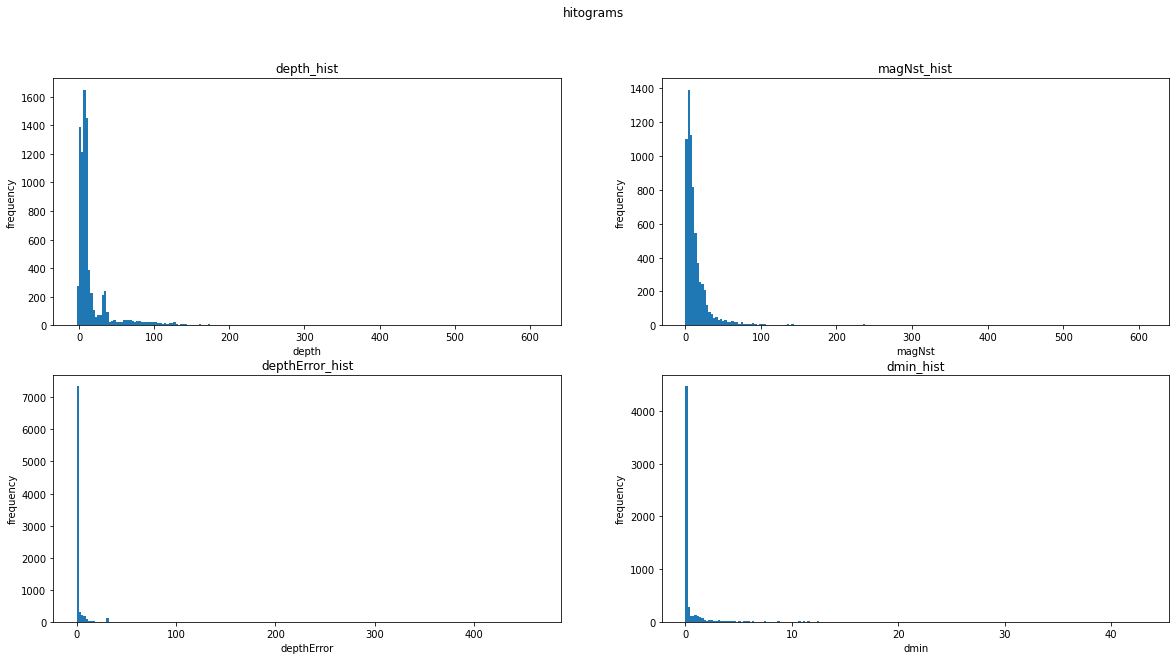

In [84]:
fig=plt.figure(figsize=(20,10))
hist_columns=['depth','magNst','depthError','dmin']
ranges=[()]
for i in range(4):
  ax=fig.add_subplot(2,2,i+1)
  ax.hist(train_data[hist_columns[i]],bins=200)
  ax.set_xlabel(hist_columns[i])
  ax.set_ylabel('frequency')
  ax.set_title(hist_columns[i]+'_'+'hist')

fig.suptitle('hitograms')
plt.show


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


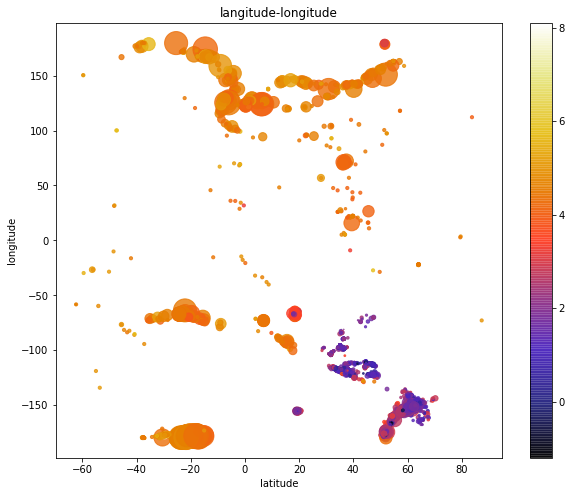

In [ ]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
t=ax.scatter(x=train_data['latitude'],
             y=train_data['longitude'],
             s=train_data['depth'],
             c=train_data['mag'],
             cmap='CMRmap',alpha=0.8)
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_title('langitude-longitude')
fig.colorbar(t)

In [85]:
trainY_mag,trainY_latitude,trainY_longitude=train_data['mag'].copy(),train_data['latitude'].copy(),train_data['longitude'].copy()

testY_mag,testY_latitude,testY_longitude=test_data['mag'].copy(),test_data['latitude'].copy(),test_data['longitude'].copy()

valY_mag,valY_latitude,valY_longitude=val_data['mag'].copy(),val_data['latitude'].copy(),val_data['longitude'].copy()

trainX_mag,trainX_latitude,trainX_longitude=train_data.drop(columns=['mag']).copy(),train_data.drop(columns=['latitude']).copy(),train_data.drop(columns=['longitude']).copy()

testX_mag,testX_latitude,testX_longitude=test_data.drop(columns=['mag']).copy(),test_data.drop(columns=['latitude']).copy(),test_data.drop(columns=['longitude']).copy()

valX_mag,valX_latitude,valX_longitude=val_data.drop(columns=['mag']).copy(),val_data.drop(columns=['latitude']).copy(),val_data.drop(columns=['longitude']).copy()

In [86]:
train_data.head()

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
3288,44.395333,-114.732167,5.62,1.80,ml,8.0,123.0,0.255000,0.22,mb,earthquake,0.66,3.37,0.119000,8.0,reviewed,mb,mb
2512,19.447833,-155.599500,-0.98,0.66,md,9.0,90.0,NaN,0.07,hv,earthquake,0.31,0.23,0.157367,7.0,reviewed,hv,hv
8929,55.045200,-159.377400,11.80,2.20,ml,NaN,NaN,NaN,0.72,ak,earthquake,NaN,0.80,NaN,NaN,reviewed,ak,ak
7007,38.746498,-122.710503,1.10,1.05,md,8.0,205.0,0.018790,0.02,nc,earthquake,0.69,0.55,0.200000,2.0,automatic,nc,nc
266,38.819668,-122.798500,2.38,0.87,md,22.0,37.0,0.009777,0.02,nc,earthquake,0.23,0.43,0.290000,5.0,automatic,nc,nc


In [87]:
trainX_mag.shape,trainX_latitude.shape,trainX_longitude.shape,trainY_mag.shape,trainY_longitude.shape,trainY_latitude.shape

((8301, 17), (8301, 17), (8301, 17), (8301,), (8301,), (8301,))

In [109]:
testX_mag.shape,testX_latitude.shape,testX_longitude.shape,testY_mag.shape,testY_longitude.shape,testY_latitude.shape

((1287, 17), (1287, 17), (1287, 17), (1287,), (1287,), (1287,))

In [ ]:
print(trainX_mag.columns)
print()
print(valX_mag.columns)
print()
print(testX_mag.columns)

In [ ]:
print(trainX_mag.isnull().sum())
print()
print(valX_mag.isnull().sum())
print()
print(testX_mag.isnull().sum())
print()


In [ ]:
print(trainX_latitude.isnull().sum())
print()
print(valX_latitude.isnull().sum())
print()
print(testX_latitude.isnull().sum())
print()


In [ ]:
print(trainX_longitude.isnull().sum())
print()
print(valX_longitude.isnull().sum())
print()
print(testX_longitude.isnull().sum())
print()

In [ ]:
print(trainX_mag[non_numeric_columns].isnull().sum())
print()
print(valX_mag[non_numeric_columns].isnull().sum())
print()
print(testX_mag[non_numeric_columns].isnull().sum())
print()

In [ ]:
print(trainX_latitude[non_numeric_columns].isnull().sum())
print()
print(valX_latitude[non_numeric_columns].isnull().sum())
print()
print(testX_latitude[non_numeric_columns].isnull().sum())
print()

In [ ]:
print(trainX_longitude[non_numeric_columns].isnull().sum())
print()
print(valX_longitude[non_numeric_columns].isnull().sum())
print()
print(testX_longitude[non_numeric_columns].isnull().sum())
print()

In [89]:
valX_mag.shape,valX_latitude.shape,valX_longitude.shape,valY_mag.shape,valY_longitude.shape,valY_latitude.shape

((1132, 17), (1132, 17), (1132, 17), (1132,), (1132,), (1132,))

In [90]:
non_numeric_columns=['magType','net','type','status','locationSource','magSource',]

numeric_columns_mag=[st for st in list(trainX_mag.columns) if st not in non_numeric_columns]

numeric_columns_longitude=[st for st in list(trainX_longitude.columns) if st not in non_numeric_columns]

numeric_columns_latitude=[st for st in list(trainX_latitude.columns) if st not in non_numeric_columns]

In [119]:
[st for st in list(trainX_mag.columns) if st not in non_numeric_columns]==[st for st in list(valX_mag.columns) if st not in non_numeric_columns]==[st for st in list(testX_mag.columns) if st not in non_numeric_columns]

True

In [120]:
[st for st in list(trainX_longitude.columns) if st not in non_numeric_columns]==[st for st in list(valX_longitude.columns) if st not in non_numeric_columns]==[st for st in list(testX_longitude.columns) if st not in non_numeric_columns]

True

In [121]:
[st for st in list(trainX_latitude.columns) if st not in non_numeric_columns]==[st for st in list(valX_latitude.columns) if st not in non_numeric_columns]==[st for st in list(testX_latitude.columns) if st not in non_numeric_columns]

True

In [91]:
numeric_columns_mag

['latitude',
 'longitude',
 'depth',
 'nst',
 'gap',
 'dmin',
 'rms',
 'horizontalError',
 'depthError',
 'magError',
 'magNst']

In [122]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [93]:
pipeline_mag=Pipeline([
                    ('impute',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())
])
pipeline_latitude=Pipeline([
                    ('impute',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())
])
pipeline_longitude=Pipeline([
                    ('impute',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())
])

arr=pipeline_mag.fit_transform(trainX_mag.loc[:,numeric_columns_mag].copy())

train_numeric_mag=pd.DataFrame(arr,columns=numeric_columns_mag)

arr=pipeline_latitude.fit_transform(trainX_latitude.loc[:,numeric_columns_latitude].copy())

train_numeric_latitude=pd.DataFrame(arr,columns=numeric_columns_latitude)

arr=pipeline_longitude.fit_transform(trainX_longitude.loc[:,numeric_columns_longitude].copy())

train_numeric_longitude=pd.DataFrame(arr,columns=numeric_columns_longitude)


In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
train_numeric_mag.corr()

,latitude,longitude,depth,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
latitude,1.000000,-0.294964,-0.125315,-0.094459,-0.101895,-0.456729,-0.217637,-0.655708,-0.054768,-0.076491,-0.194957
longitude,-0.294964,1.000000,0.087971,-0.008176,-0.027043,0.234395,0.232711,0.433819,0.092927,-0.116293,0.180780
depth,-0.125315,0.087971,1.000000,-0.015989,0.000159,0.142494,0.271218,0.343222,0.094997,0.003872,0.144998
nst,-0.094459,-0.008176,-0.015989,1.000000,-0.311366,-0.049836,-0.055334,-0.108899,-0.082944,0.180077,0.182724
gap,-0.101895,-0.027043,0.000159,-0.311366,1.000000,0.047913,-0.017149,0.177832,0.110621,0.088746,-0.145601
dmin,-0.456729,0.234395,0.142494,-0.049836,0.047913,1.000000,0.355484,0.642186,0.050193,-0.064267,0.230060
rms,-0.217637,0.232711,0.271218,-0.055334,-0.017149,0.355484,1.000000,0.585644,0.083306,-0.126369,0.271608
horizontalError,-0.655708,0.433819,0.343222,-0.108899,0.177832,0.642186,0.585644,1.000000,0.148371,-0.095076,0.308818
depthError,-0.054768,0.092927,0.094997,-0.082944,0.110621,0.050193,0.083306,0.148371,1.000000,-0.035027,0.032405
magError,-0.076491,-0.116293,0.003872,0.180077,0.088746,-0.064267,-0.126369,-0.095076,-0.035027,1.000000,-0.081527


In [96]:
train_numeric_longitude.corr()

,latitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
latitude,1.000000,-0.125315,-0.618694,-0.094459,-0.101895,-0.456729,-0.217637,-0.655708,-0.054768,-0.076491,-0.194957
depth,-0.125315,1.000000,0.289972,-0.015989,0.000159,0.142494,0.271218,0.343222,0.094997,0.003872,0.144998
mag,-0.618694,0.289972,1.000000,0.141767,0.007857,0.503007,0.671703,0.768255,0.098424,-0.015119,0.416137
nst,-0.094459,-0.015989,0.141767,1.000000,-0.311366,-0.049836,-0.055334,-0.108899,-0.082944,0.180077,0.182724
gap,-0.101895,0.000159,0.007857,-0.311366,1.000000,0.047913,-0.017149,0.177832,0.110621,0.088746,-0.145601
dmin,-0.456729,0.142494,0.503007,-0.049836,0.047913,1.000000,0.355484,0.642186,0.050193,-0.064267,0.230060
rms,-0.217637,0.271218,0.671703,-0.055334,-0.017149,0.355484,1.000000,0.585644,0.083306,-0.126369,0.271608
horizontalError,-0.655708,0.343222,0.768255,-0.108899,0.177832,0.642186,0.585644,1.000000,0.148371,-0.095076,0.308818
depthError,-0.054768,0.094997,0.098424,-0.082944,0.110621,0.050193,0.083306,0.148371,1.000000,-0.035027,0.032405
magError,-0.076491,0.003872,-0.015119,0.180077,0.088746,-0.064267,-0.126369,-0.095076,-0.035027,1.000000,-0.081527


In [97]:
train_numeric_latitude.corr()

,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
longitude,1.000000,0.087971,0.441180,-0.008176,-0.027043,0.234395,0.232711,0.433819,0.092927,-0.116293,0.180780
depth,0.087971,1.000000,0.289972,-0.015989,0.000159,0.142494,0.271218,0.343222,0.094997,0.003872,0.144998
mag,0.441180,0.289972,1.000000,0.141767,0.007857,0.503007,0.671703,0.768255,0.098424,-0.015119,0.416137
nst,-0.008176,-0.015989,0.141767,1.000000,-0.311366,-0.049836,-0.055334,-0.108899,-0.082944,0.180077,0.182724
gap,-0.027043,0.000159,0.007857,-0.311366,1.000000,0.047913,-0.017149,0.177832,0.110621,0.088746,-0.145601
dmin,0.234395,0.142494,0.503007,-0.049836,0.047913,1.000000,0.355484,0.642186,0.050193,-0.064267,0.230060
rms,0.232711,0.271218,0.671703,-0.055334,-0.017149,0.355484,1.000000,0.585644,0.083306,-0.126369,0.271608
horizontalError,0.433819,0.343222,0.768255,-0.108899,0.177832,0.642186,0.585644,1.000000,0.148371,-0.095076,0.308818
depthError,0.092927,0.094997,0.098424,-0.082944,0.110621,0.050193,0.083306,0.148371,1.000000,-0.035027,0.032405
magError,-0.116293,0.003872,-0.015119,0.180077,0.088746,-0.064267,-0.126369,-0.095076,-0.035027,1.000000,-0.081527


In [166]:
pipeline_mag=Pipeline([
                    ('impute',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())
])
pipeline_latitude=Pipeline([
                    ('impute',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())
])
pipeline_longitude=Pipeline([
                    ('impute',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())
])


encode=OneHotEncoder()
encode.fit(shuffle1.loc[:,non_numeric_columns].copy())








OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [171]:
def rename_columns(arr,numeric_columns):
  t=pd.DataFrame(arr)
  
  t=t.rename(columns=dict(list(zip(range(len(numeric_columns)),numeric_columns))))
  print(t.shape)
  return t

In [174]:
we=pipeline_mag.fit_transform(trainX_mag.loc[:,numeric_columns_mag].copy())
te=encode.transform(trainX_mag.loc[:,non_numeric_columns].copy())
p=te.toarray()
trainX_mag2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_mag)
we=pipeline_latitude.fit_transform(trainX_latitude.loc[:,numeric_columns_latitude].copy())
te=encode.transform(trainX_latitude.loc[:,non_numeric_columns].copy())
p=te.toarray()
trainX_latitude2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_latitude)
we=pipeline_longitude.fit_transform(trainX_longitude.loc[:,numeric_columns_longitude].copy())
te=encode.transform(trainX_longitude.loc[:,non_numeric_columns].copy())
p=te.toarray()
trainX_longitude2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_longitude)


(8301, 76)
(8301, 76)
(8301, 76)


In [176]:
we=pipeline_mag.transform(valX_mag.loc[:,numeric_columns_mag].copy())
te=encode.transform(valX_mag.loc[:,non_numeric_columns].copy())
p=te.toarray()
valX_mag2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_mag)
we=pipeline_latitude.transform(valX_latitude.loc[:,numeric_columns_latitude].copy())
te=encode.transform(valX_latitude.loc[:,non_numeric_columns].copy())
p=te.toarray()
valX_latitude2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_latitude)
we=pipeline_longitude.transform(valX_longitude.loc[:,numeric_columns_longitude].copy())
te=encode.transform(valX_longitude.loc[:,non_numeric_columns].copy())
p=te.toarray()
valX_longitude2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_longitude)

(1132, 76)
(1132, 76)
(1132, 76)


In [177]:
we=pipeline_mag.transform(testX_mag.loc[:,numeric_columns_mag].copy())
te=encode.transform(testX_mag.loc[:,non_numeric_columns].copy())
p=te.toarray()
testX_mag2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_mag)
we=pipeline_latitude.transform(testX_latitude.loc[:,numeric_columns_latitude].copy())
te=encode.transform(testX_latitude.loc[:,non_numeric_columns].copy())
p=te.toarray()
testX_latitude2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_latitude)
we=pipeline_longitude.transform(testX_longitude.loc[:,numeric_columns_longitude].copy())
te=encode.transform(testX_longitude.loc[:,non_numeric_columns].copy())
p=te.toarray()
testX_longitude2=rename_columns(np.concatenate([we,p],axis=1),numeric_columns_longitude)

(1287, 76)
(1287, 76)
(1287, 76)


In [175]:
trainX_mag2.head()

,latitude,longitude,depth,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
0,0.422427,-0.021077,-0.297784,-0.933836,0.241843,-0.135778,-0.282980,-0.319299,0.205514,-0.287200,-0.245093,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.680892,-0.640763,-0.433550,-0.861864,-0.363703,-0.226639,-0.793147,-0.435066,-0.261501,-0.190200,-0.280871,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.893424,-0.698049,-0.170659,-0.214120,-0.235254,-0.226639,1.417575,-0.372221,-0.176724,-0.173431,-0.209315,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.172604,-0.142056,-0.390763,-0.933836,1.746533,-0.253499,-0.963202,-0.309376,-0.213907,-0.082416,-0.459761,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.175840,-0.143390,-0.364433,0.073766,-1.336247,-0.257991,-0.963202,-0.461527,-0.231754,0.145121,-0.352427,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfg=RandomForestRegressor(n_estimators=400,max_depth=16,oob_score=True,random_state=45)


In [ ]:
rfg.fit(trainX_mag2.values,trainY_mag.values)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=True,
                      random_state=45, verbose=0, warm_start=False)

In [ ]:
rfg.oob_score_


0.9408233756119443

In [48]:
from sklearn.metrics import mean_squared_error

In [108]:
valX_latitude.columns,valX_mag.columns

(Index(['longitude', 'depth', 'mag', 'magType', 'nst', 'gap', 'dmin', 'rms',
        'net', 'type', 'horizontalError', 'depthError', 'magError', 'magNst',
        'status', 'locationSource', 'magSource'],
       dtype='object'),
 Index(['latitude', 'longitude', 'depth', 'magType', 'nst', 'gap', 'dmin',
        'rms', 'net', 'type', 'horizontalError', 'depthError', 'magError',
        'magNst', 'status', 'locationSource', 'magSource'],
       dtype='object'))

In [123]:
we=column_mag.transform(valX_mag)
valX_mag2=rename_columns(we,numeric_columns_mag)


(1132, 74)


In [131]:
we=column_longitude.transform(valX_longitude)
print(we.shape)


(1132, 72)


In [153]:
pipeline_latitude_ew=Pipeline([
                    ('impute',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())
])
encode_ew=OneHotEncoder()
pipeline_latitude_ew.fit_transform(trainX_latitude.loc[:,numeric_columns_latitude].copy())
r=pipeline_latitude_ew.transform(valX_latitude.loc[:,numeric_columns_latitude].copy())
print(r.shape)
encode_ew.fit_transform(shuffle1.loc[:,non_numeric_columns].copy())
t=encode_ew.transform(valX_latitude.loc[:,non_numeric_columns].copy())
print(t.shape)
r=pipeline_latitude_ew.transform(testX_latitude.loc[:,numeric_columns_latitude].copy())
print(r.shape)

t=encode_ew.transform(testX_latitude.loc[:,non_numeric_columns].copy())
print(t.shape)

(1132, 11)
(1132, 65)
(1287, 11)
(1287, 65)


In [151]:
pd.unique(tra.loc[:,non_numeric_columns]['magType'])

array(['mww', 'ml', 'md', 'mb', 'mb_lg', 'mwc', 'mwr', 'mw'], dtype=object)

In [152]:
train_data.shape

(8301, 18)

In [145]:
def to_categorical(arr):
  
  i=0
  for column in range(arr.shape[1]):
    uni=pd.unique(arr[:,column])
    for j in range(len(uni)):
      arr[:,column][[arr[:,column]==uni[j]]]=j
  print(arr.shape)

  for column in range(arr.shape[1]):  
    r=np.zeros((arr.shape[0],len(uni)),dtype=np.int32)
      
    for j in range(arr.shape[0]):
      r[j,arr[j,column]]=1
    if i==0:
      res=r
      i=-1
    else:
      np.concatenate([res,r],axis=1)
    
  return res



In [146]:
to_categorical(testX_latitude.loc[:,non_numeric_columns].copy().values).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


(1287, 8)

In [126]:
valX_latitude2=rename_columns(we,numeric_columns_latitude)

(1132, 74)


In [105]:

we=column_latitude.fit_transform(testX_latitude)
testX_latitude2=rename_columns(we,numeric_columns_latitude)
we=column_longitude.fit_transform(testX_longitude)
testX_longitude2=rename_columns(we,numeric_columns_longitude)

(1287, 72)
(1287, 72)


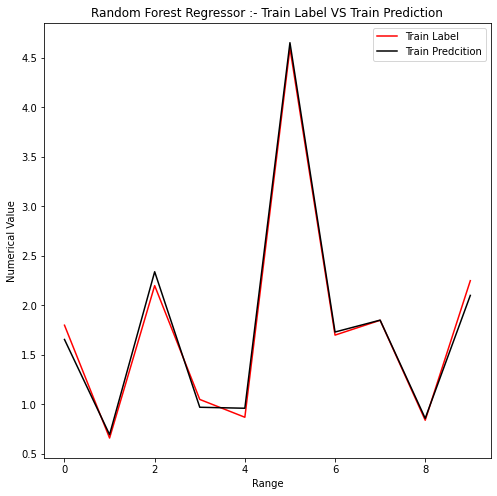

In [ ]:
r=10
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),trainY_mag[0:r],color='r',label='Train Label')
t2=ax.plot(range(r),rfg.predict(trainX_mag2[0:r]),color='k',label='Train Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Random Forest Regressor :- Train Label VS Train Prediction')
fig.show()

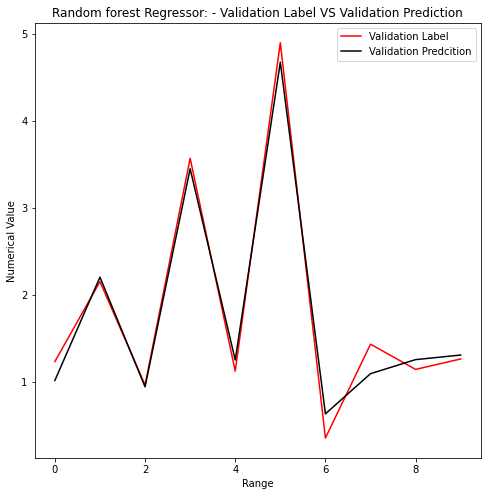

In [ ]:
r=10
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_mag[0:r],color='r',label='Validation Label')
t2=ax.plot(range(r),rfg.predict(valX_mag2[0:r]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Random forest Regressor: - Validation Label VS Validation Prediction')
fig.show()

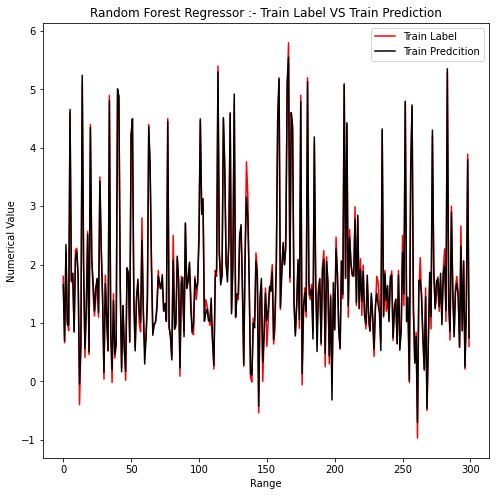

In [ ]:
r=300
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),trainY_mag[0:r],color='r',label='Train Label')
t2=ax.plot(range(r),rfg.predict(trainX_mag2[0:r]),color='k',label='Train Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Random Forest Regressor :- Train Label VS Train Prediction')
fig.show()

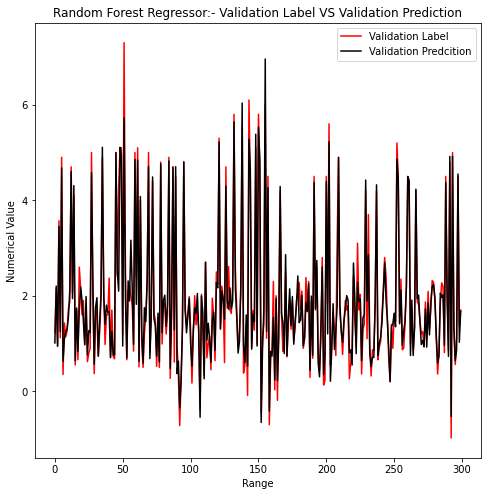

In [ ]:
r=300
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_mag[0:r],color='r',label='Validation Label')
t2=ax.plot(range(r),rfg.predict(valX_mag2[0:r]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Random Forest Regressor:- Validation Label VS Validation Prediction')
fig.show()

In [ ]:
mean_squared_error(trainY_mag,rfg.predict(trainX_mag2))

0.02598363379801677

In [ ]:
mean_squared_error(valY_mag,rfg.predict(valX_mag2))

0.10210292994451789

In [ ]:
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingRegressor

In [ ]:
xgb=XGBRegressor(max_depth=16,learning_rate=0.1,n_estimators=300,random_state=46,early_stopping_rounds=10,objective='reg:squarederror')
svr=SVR(max_iter=400,kernel='rbf',C=0.1)
rfg_new=RandomForestRegressor(n_estimators=300,max_depth=30,min_samples_leaf=30,random_state=46)


In [ ]:
xgb.fit(trainX_mag2,trainY_mag)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=16, min_child_weight=1, missing=None,
             n_estimators=300, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=46, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [ ]:
mean_squared_error(trainY_mag,xgb.predict(trainX_mag2))


6.464149008237083e-06

In [ ]:
mean_squared_error(valY_mag,xgb.predict(valX_mag2))


0.10825907217081836

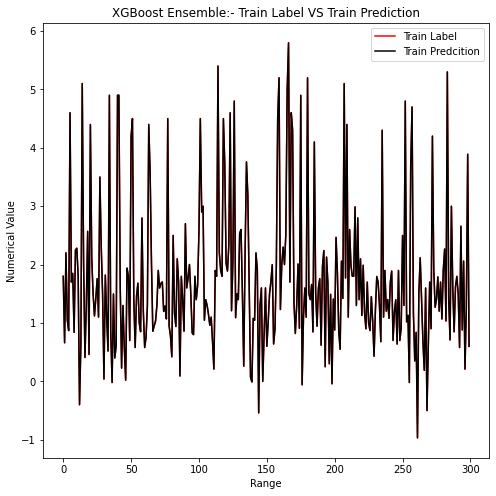

In [ ]:
r=300
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),trainY_mag[0:r],color='r',label='Train Label')
t2=ax.plot(range(r),xgb.predict(trainX_mag2[0:r]),color='k',label='Train Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('XGBoost Ensemble:- Train Label VS Train Prediction')
fig.show()

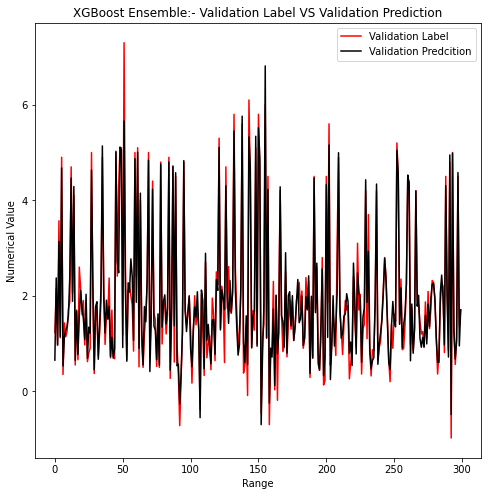

In [ ]:
r=300
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_mag[0:r],color='r',label='Validation Label')
t2=ax.plot(range(r),xgb.predict(valX_mag2[0:r]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('XGBoost Ensemble:- Validation Label VS Validation Prediction')
fig.show()

In [ ]:
svr.fit(trainX_mag2,trainY_mag)
rfg_new.fit(trainX_mag2,trainY_mag)

In [ ]:
mean_squared_error(trainY_mag,svr.predict(trainX_mag2))

0.3567200630521693

In [ ]:
mean_squared_error(valY_mag,svr.predict(valX_mag2))

0.40480847006477844

In [ ]:
vr=VotingRegressor([('xgb',xgb),
                    ('svr',svr),
                    ('rgf_new',rfg_new)])
vr.fit(trainX_mag2,trainY_mag)

In [ ]:
mean_squared_error(trainY_mag,vr.predict(trainX_mag2))

0.07900430492678541

In [ ]:
mean_squared_error(valY_mag,vr.predict(valX_mag2))

0.14313621123049028

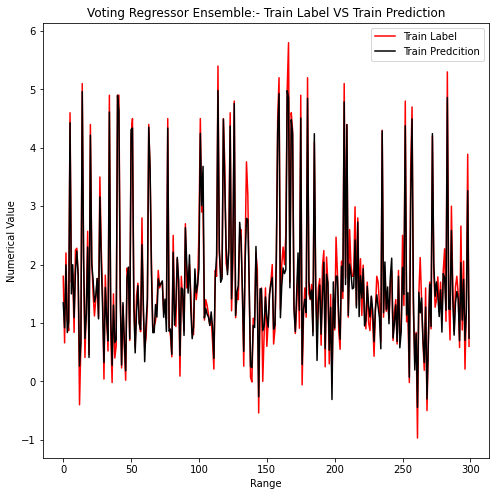

In [ ]:
r=300
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),trainY_mag[0:r],color='r',label='Train Label')
t2=ax.plot(range(r),vr.predict(trainX_mag2[0:r]),color='k',label='Train Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Voting Regressor Ensemble:- Train Label VS Train Prediction')
fig.show()

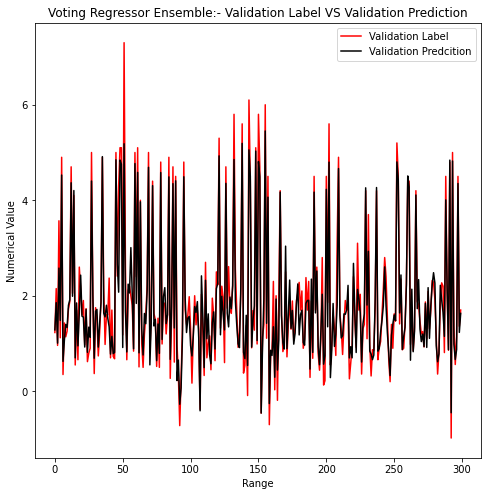

In [ ]:
r=300
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_mag[0:r],color='r',label='Validation Label')
t2=ax.plot(range(r),vr.predict(valX_mag2[0:r]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Voting Regressor Ensemble:- Validation Label VS Validation Prediction')
fig.show()

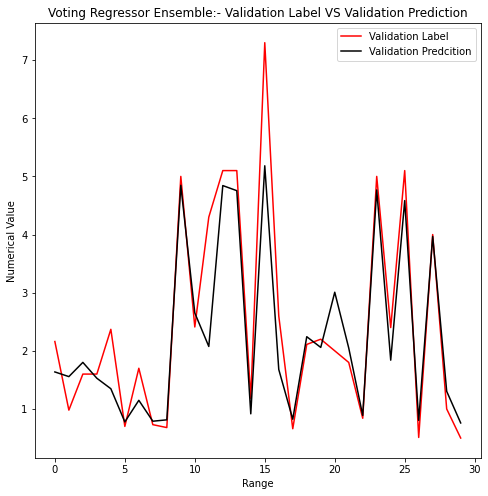

In [ ]:
r=30
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_mag[36:r+36],color='r',label='Validation Label')
t2=ax.plot(range(r),vr.predict(valX_mag2[36:r+36]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Voting Regressor Ensemble:- Validation Label VS Validation Prediction')
fig.show()

In [196]:
input=keras.Input(shape=(76,))
z=keras.layers.Dense(200,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(input)
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dense(200,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Concatenate()([input,z])
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dropout(0.3)(z)
al=keras.layers.Dense(200,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Dense(200,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(al)
z=keras.layers.Add()([al,z])
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dropout(0.3)(z)

z=keras.layers.Dense(200,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Dropout(0.3)(z)
z=keras.layers.Dense(200,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)

z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dense(200,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
output=keras.layers.Dense(1,activation='relu')(z)

model=keras.Model(inputs=[input],outputs=[output])


In [187]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 200)          15400       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 200)          800         dense_16[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 200)          40200       batch_normalization_8[0][0]      
____________________________________________________________________________________________

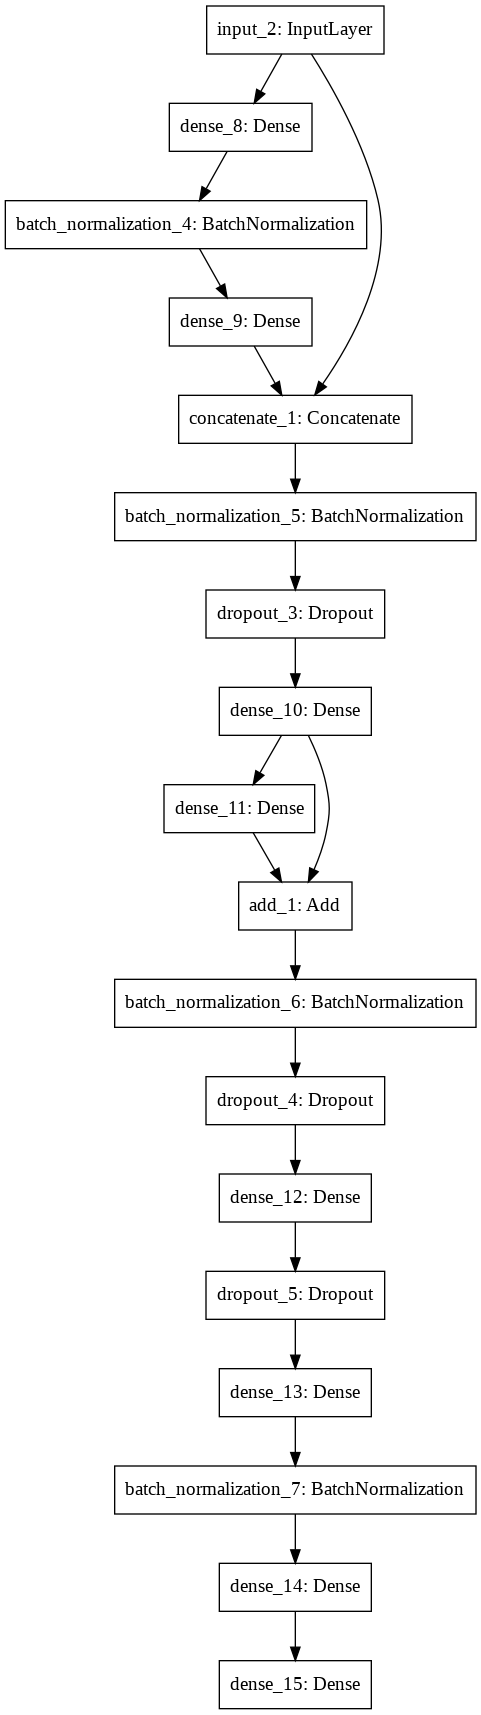

In [183]:
keras.utils.plot_model(model)

In [197]:
model.compile(loss='mae',optimizer=keras.optimizers.SGD(0.001,nesterov=True),
              metrics=[keras.metrics.MeanSquaredError(),keras.metrics.MeanAbsoluteError()])


In [199]:
early_stopping=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/keras model1.png',save_best_only=True)
lr=keras.callbacks.ReduceLROnPlateau()
history=model.fit(trainX_mag2,trainY_mag,epochs=200,validation_data=(valX_mag2,valY_mag),callbacks=[model_checkpoint,lr])

Epoch 1/200
260/260 [==============================] - 1s 6ms/step - loss: 0.3598 - mean_squared_error: 0.2268 - mean_absolute_error: 0.3598 - val_loss: 0.3174 - val_mean_squared_error: 0.3322 - val_mean_absolute_error: 0.3174
INFO:tensorflow:Assets written to: /content/drive/MyDrive/keras model1.png/assets
Epoch 2/200
260/260 [==============================] - 1s 5ms/step - loss: 0.3585 - mean_squared_error: 0.2257 - mean_absolute_error: 0.3585 - val_loss: 0.3236 - val_mean_squared_error: 0.2257 - val_mean_absolute_error: 0.3236
Epoch 3/200
260/260 [==============================] - 1s 5ms/step - loss: 0.3548 - mean_squared_error: 0.2235 - mean_absolute_error: 0.3548 - val_loss: 0.3339 - val_mean_squared_error: 0.4123 - val_mean_absolute_error: 0.3339
Epoch 4/200
260/260 [==============================] - 1s 5ms/step - loss: 0.3547 - mean_squared_error: 0.2238 - mean_absolute_error: 0.3547 - val_loss: 0.3112 - val_mean_squared_error: 0.1898 - val_mean_absolute_error: 0.3112
INFO:tenso

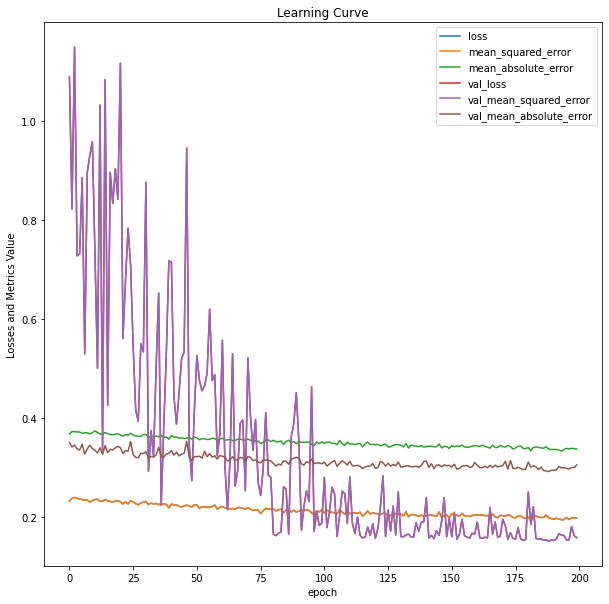

In [191]:
df=pd.DataFrame(history.history)
df.plot(xlabel='epoch',ylabel='Losses and Metrics Value',title='Learning Curve',figsize=(10,10))
plt.show()

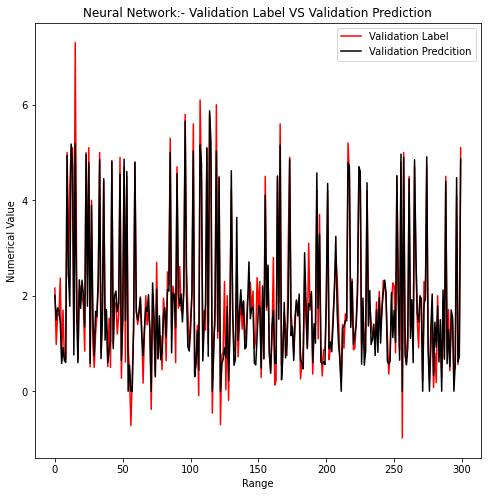

In [200]:
r=300
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_mag[36:r+36],color='r',label='Validation Label')
t2=ax.plot(range(r),model.predict(valX_mag2[36:r+36]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Neural Network:- Validation Label VS Validation Prediction')
fig.show()

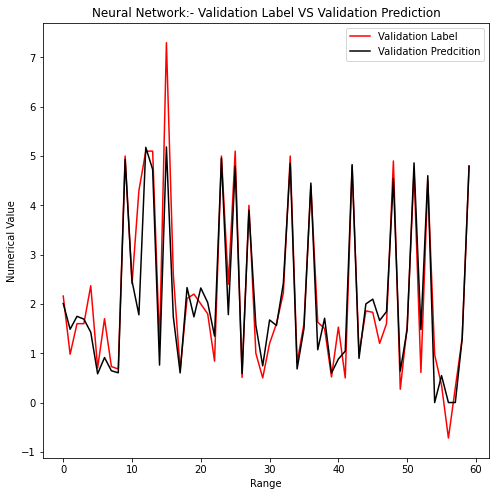

In [201]:
r=60
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_mag[36:r+36],color='r',label='Validation Label')
t2=ax.plot(range(r),model.predict(valX_mag2[36:r+36]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Neural Network:- Validation Label VS Validation Prediction')
fig.show()

In [202]:
model.evaluate(testX_mag2,testY_mag)

41/41 [==============================] - 0s 2ms/step - loss: 0.3027 - mean_squared_error: 0.1700 - mean_absolute_error: 0.3027


[0.3027442693710327, 0.17000503838062286, 0.3027442693710327]

In [195]:
best_model=keras.models.load_model('/content/drive/MyDrive/keras model.png')
print(best_model.predict(testX_mag2.iloc[30:40,:]))
print()
print(testY_mag.iloc[30:40])

[[0.9369487 ]
 [1.7001364 ]
 [1.3803747 ]
 [0.6707376 ]
 [1.112419  ]
 [1.5709534 ]
 [4.516613  ]
 [0.71173805]
 [1.0586901 ]
 [1.5027401 ]]

10356    1.41
9958     2.28
5277     0.90
8913     0.74
9652     1.38
7491     1.80
5453     4.50
3870     0.95
6841     1.00
6181     1.10
Name: mag, dtype: float64


In [256]:
input=keras.Input(shape=(76,))
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(input)
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Concatenate()([input,z])
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dropout(0.3)(z)
al=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(al)
z=keras.layers.Add()([al,z])
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dropout(0.3)(z)

z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Dropout(0.3)(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)

z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
output=keras.layers.Dense(1)(z)

model_latitude=keras.Model(inputs=[input],outputs=[output])

In [257]:
model_latitude.compile(loss='mse',optimizer=keras.optimizers.SGD(0.001,nesterov=True),
              metrics=[keras.metrics.MeanSquaredError(),keras.metrics.MeanAbsoluteError()])

In [258]:
early_stopping=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/keras model_latitude.png',save_best_only=True)
lr=keras.callbacks.ReduceLROnPlateau()
history=model_latitude.fit(trainX_latitude2,trainY_latitude,epochs=200,validation_data=(valX_latitude2,valY_latitude),callbacks=[model_checkpoint])

Epoch 1/200
260/260 [==============================] - 5s 14ms/step - loss: 293.7453 - mean_squared_error: 293.7453 - mean_absolute_error: 11.1526 - val_loss: 304.3712 - val_mean_squared_error: 304.3712 - val_mean_absolute_error: 7.0908
INFO:tensorflow:Assets written to: /content/drive/MyDrive/keras model_latitude.png/assets
Epoch 2/200
260/260 [==============================] - 3s 12ms/step - loss: 124.3920 - mean_squared_error: 124.3920 - mean_absolute_error: 6.0886 - val_loss: 107.9495 - val_mean_squared_error: 107.9495 - val_mean_absolute_error: 6.7594
INFO:tensorflow:Assets written to: /content/drive/MyDrive/keras model_latitude.png/assets
Epoch 3/200
260/260 [==============================] - 3s 12ms/step - loss: 91.4264 - mean_squared_error: 91.4264 - mean_absolute_error: 5.0619 - val_loss: 85.8385 - val_mean_squared_error: 85.8385 - val_mean_absolute_error: 5.1245
INFO:tensorflow:Assets written to: /content/drive/MyDrive/keras model_latitude.png/assets
Epoch 4/200
260/260 [====

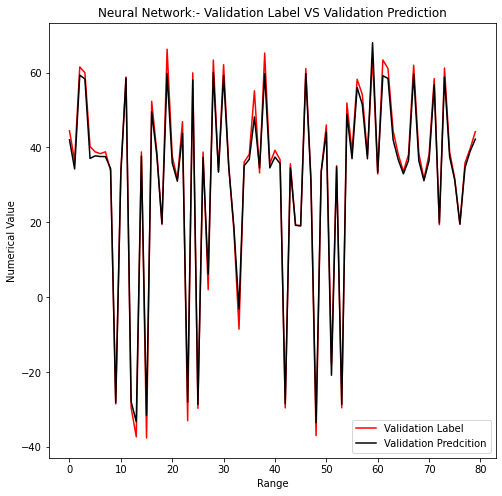

In [259]:
r=80
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_latitude[36:r+36],color='r',label='Validation Label')
t2=ax.plot(range(r),model_latitude.predict(valX_latitude2[36:r+36]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Neural Network:- Validation Label VS Validation Prediction')
fig.show()

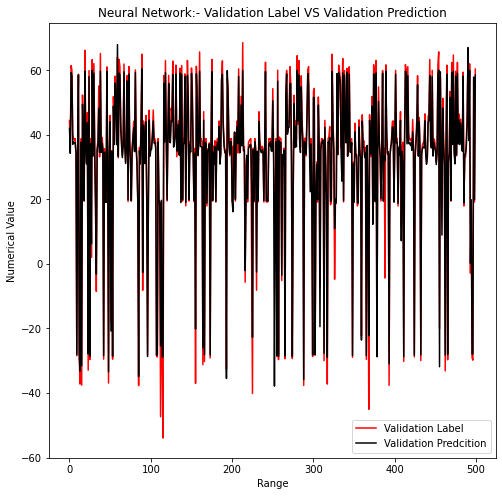

In [260]:
r=500
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_latitude[36:r+36],color='r',label='Validation Label')
t2=ax.plot(range(r),model_latitude.predict(valX_latitude2[36:r+36]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Neural Network:- Validation Label VS Validation Prediction')
fig.show()

In [261]:
mean_squared_error(testY_latitude,model_latitude.predict(testX_latitude2))

36.23010564447934

In [277]:
input=keras.Input(shape=(76,))
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(input)
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Concatenate()([input,z])
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dropout(0.3)(z)
al=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(al)
z=keras.layers.Add()([al,z])
z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dropout(0.3)(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
z=keras.layers.Dropout(0.3)(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)

z=keras.layers.BatchNormalization()(z)
z=keras.layers.Dense(400,activation='elu',kernel_initializer=keras.initializers.HeNormal(47))(z)
output=keras.layers.Dense(1)(z)

model_longitude=keras.Model(inputs=[input],outputs=[output])

In [278]:
model_longitude.compile(loss='mse',optimizer=keras.optimizers.Adam(0.001),
              metrics=[keras.metrics.MeanSquaredError(),keras.metrics.MeanAbsoluteError()])

In [279]:
early_stopping=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/keras model_longitude.png',save_best_only=True)
lr=keras.callbacks.ReduceLROnPlateau()
history=model_longitude.fit(trainX_longitude2,trainY_longitude,epochs=200,validation_data=(valX_longitude2,valY_longitude),callbacks=[model_checkpoint])

Epoch 1/200
260/260 [==============================] - 6s 16ms/step - loss: 7593.6768 - mean_squared_error: 7593.6768 - mean_absolute_error: 67.0286 - val_loss: 71801.8516 - val_mean_squared_error: 71801.8516 - val_mean_absolute_error: 45.9461
INFO:tensorflow:Assets written to: /content/drive/MyDrive/keras model_longitude.png/assets
Epoch 2/200
260/260 [==============================] - 4s 14ms/step - loss: 2422.1721 - mean_squared_error: 2422.1721 - mean_absolute_error: 24.8144 - val_loss: 32616.8867 - val_mean_squared_error: 32616.8867 - val_mean_absolute_error: 31.3157
INFO:tensorflow:Assets written to: /content/drive/MyDrive/keras model_longitude.png/assets
Epoch 3/200
260/260 [==============================] - 3s 13ms/step - loss: 2269.4736 - mean_squared_error: 2269.4736 - mean_absolute_error: 22.0976 - val_loss: 17251.0742 - val_mean_squared_error: 17251.0742 - val_mean_absolute_error: 31.0664
INFO:tensorflow:Assets written to: /content/drive/MyDrive/keras model_longitude.png/as

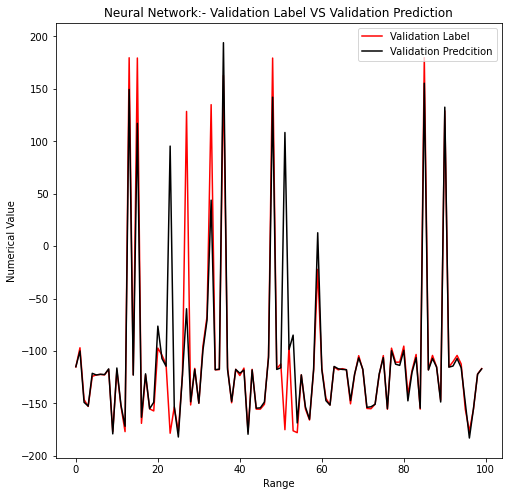

In [282]:
r=100
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
t1=ax.plot(range(r),valY_longitude[36:r+36],color='r',label='Validation Label')
t2=ax.plot(range(r),model_longitude.predict(valX_longitude2[36:r+36]),color='k',label='Validation Predcition')
ax.set_xlabel('Range',)
ax.set_ylabel('Numerical Value')
ax.legend()
ax.set_title('Neural Network:- Validation Label VS Validation Prediction')
fig.show()